# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

see link to [forcing description](https://github.com/slgentil/croco/blob/master/configs/itbalt/readme.ipynb)

Diagnostics to store:

- surface: 
    - time and x averaged KE(y)
    - time and x averaged relative enstrophy (y)
    - time averaged horizontal wavenumber spectra

- with depth information:
    - time and x averaged KE(z, y)
    - time and x averaged relative enstrophy (z, y)

- time series of x and y averaged modal KE

In [1]:
from glob import glob
import itertools

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=8, cores=16)
w = cluster.scale(jobs=4)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.68:48840 Dashboard: http://10.148.1.68:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## diagnostic flags and runs

In [33]:
# flags
flags = {'surface': True, 'spectra': True, 'depth': True, 'vmodes': True}
overwrite=True

#root_path = '/home/c11-data/Test_aponte/fsturb/'
root_path = '/home/datawork-lops-osi/equinox/itbalt/'
#
#runs = ['fsturb_4km_m1_Nexp_0a1000j']
#
#M, B = [0,1], [0,1,2,3]
#runs = ['fsturb_m{}_b{}_4km_0a1000j'.format(m,b) for m, b in itertools.product(M, B)]
#
#M, A = [0,1], [0,1,2,3]
#runs = ['fsturb_m{}_a{}_4km_0a600j'.format(m,a) for m, a in itertools.product(M, A)]
#
M, L = [0,1], [0,1]
runs = ['fsturb_m{}_l{}_4km_0a600j'.format(m,l) for m, l in itertools.product(M, L)]
#
#M, Mi = [0,1], [1]
#runs = ['itbalt_m{}_m{}_4km_300a600j'.format(m,mi) for m, mi in itertools.product(M, Mi)]

_ = [print(r) for r in runs]

fsturb_m0_l0_4km_0a600j
fsturb_m0_l1_4km_0a600j
fsturb_m1_l0_4km_0a600j
fsturb_m1_l1_4km_0a600j


## Load data

In [34]:
R = [pp.Run(root_path+run, outputs=['surf', 'his'], 
           grid_periodicity=True,
           ) for run in runs
    ]

for r in R:
    r['surf'] = r['surf'].assign_coords(time=r['surf'].time_instant.chunk({'time':None}))
    r['his'] = r['his'].assign_coords(time=r['his'].time_counter.chunk({'time':None}))
    #r['surf'] = r['surf'].rename({'time_instant': 'time'})
    #r['his'] = r['his'].rename({'time_counter': 'time'})

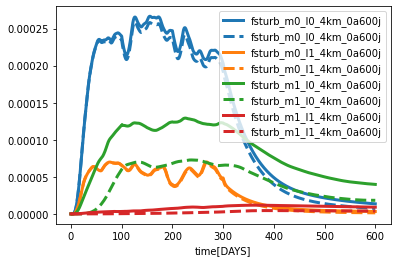

In [35]:
# quickly look at energies
fig, ax = plt.subplots()
for r, name in zip(R, runs):
    r.stats['KINETIC_ENRG'].plot(ax=ax, lw=3., label=name)
    r.stats['BTKIN_ENRG'].plot(ax=ax, lw=3., color=ax.get_lines()[-1].get_color(), ls='--', label=name)
ax.legend()


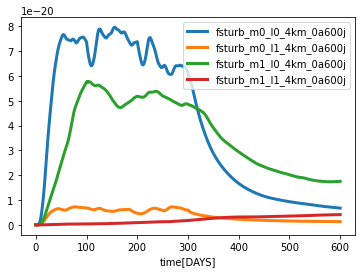

In [36]:
# quickly look at enstrophy
fig, ax = plt.subplots()
for r, name in zip(R, runs):
    r.stats['ENSTROPHY'].plot(ax=ax, lw=3., label=name)
ax.legend()

---

## surface statistics

Time and zonal average the following fields
- u, v, relative vorticity (xi), sea level (ssh)
- kinetic energy, relative enstrophy, squared sea level

In [37]:
if flags['surface']:
    
    for r in R:
        
        u = r['surf']['u']
        v = r['surf']['v']
        xi = r.get_relative_vorticity(u, v)
        ssh = r['surf']['ssh']
        
        ke = (.5*(r.x2rho(u).chunk({'x_rho': None})**2
                 +r.x2rho(v).chunk({'y_rho': None})**2)
             ).rename('kinetic_energy')
        ens = (.5*xi**2).rename('enstrophy')
        ssh2 = (ssh**2).rename('ssh2')

        ds = (xr.merge([u,v,xi,ssh,
                        ke,ens,ssh2])
              .mean(dim=['x_rho','x_u','time'])
             )

        r.store_diagnostic('surface', ds, overwrite=overwrite)

#ds = r.load_diagnostic('surface')

Create new diagnostic directory /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/surface.zarr
Create new diagnostic directory /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/surface.zarr
Create new diagnostic directory /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/surface.zarr
Create new diagnostic directory /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l1_4km_0a600j/diagnostics/
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l1_4km_0a600j/diagnostics/surface.zarr


---

## horizontal wavenumber spectra

Of the following variables:
- u, v, relative vorticity (xi)
- Eu+Ev

In [38]:
def get_spectra(v, name='E', mean=True, persist=True):
    """ Compute (2D/isotropic) spectra of variable v
    """

    # interp and rechunk:
    v = r.x2rho(v).chunk({'x_rho': None, 'y_rho': None})
    #
    Ev = (xrft.power_spectrum(v,
                             dim=['x_rho','y_rho'],
                             detrend='constant', 
                             window=True)
          .rename(name)
         )
    
    # isotropize
    Ev_iso = (xrft.isotropize(Ev, ['freq_x_rho', 'freq_y_rho'])
              .rename(name+'_iso')
             )
    #
    if mean:
        Ev = Ev.mean('time')
        Ev_iso = Ev_iso.mean('time')
    #
    if persist:
        Ev = Ev.persist()
        Ev_iso = Ev_iso.persist()
    #
    return Ev, Ev_iso

In [39]:
if flags['spectra']:

    for r in R:

        u, v = r['surf']['u'], r['surf']['v']
        xi = r.get_relative_vorticity(u, v)

        Eu, Eu_iso = get_spectra(u, name='Eu')
        Ev, Ev_iso = get_spectra(v, name='Ev')
        Euv = .5*(Eu + Ev).rename('Euv')
        Euv_iso = .5*(Eu_iso + Ev_iso).rename('Euv_iso')

        Exi, Exi_iso = get_spectra(xi, name='Exi')

        ds = xr.merge([Eu,Eu_iso,
                       Ev,Ev_iso,
                       Euv, Euv_iso,
                       Exi, Exi_iso])
        
        r.store_diagnostic('spectra', ds, overwrite=overwrite)
        
#ds = r.load_diagnostic('spectra')

data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/spectra.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/spectra.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/spectra.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l1_4km_0a600j/diagnostics/spectra.zarr


---

## depth dependent statistics

Zonal and temporal average of:
- u, v, relative vorticity
- kinetic energy, relative enstrophy
- stratification


In [40]:
if flags['depth']:

    for r in R:

        ds = r['his']
        
        # should in principle interpolate on fixed levels
        u = ds['u_t_dirac'].rename('u') 
        v = ds['v_t_dirac'].rename('v')
        
        xi = r.get_relative_vorticity(u, v)
        
        rho = ds['T_t_dirac'].rename('rho')
        ssh = (ds['ssh_t_dirac']
               .rename('ssh')
               .chunk({'time': max(rho.chunks[rho.get_axis_num('time')])})
              )
        
        z_r = r.get_z(ssh)
        z_w = r.get_z(ssh, vgrid='w')

        p = r.get_p(rho, z_w, zr=z_r)

        ke = (.5*(r.x2rho(u).chunk({'x_rho': None})**2
                 +r.x2rho(v).chunk({'y_rho': None})**2)
             ).rename('kinetic_energy')
        ens = (.5*xi**2).rename('enstrophy')
        
        ds_diag = (xr.merge([u, v, xi, rho,
                             ssh, z_r, z_w,
                             p,
                             ke, ens,
                            ])
                   .mean(dim=['x_rho','x_u','time'])
                   .chunk({'s_rho': -1, 's_w':-1})
                  ).persist()
        
        # add mean stratification
        ds_diag['N2'] = (r.get_N2(ds_diag['rho'], ds_diag['z_rho'])
                         .chunk({'s_w':-1})
                        )

        r.store_diagnostic('depth', ds_diag, overwrite=overwrite)

#ds = r.load_diagnostic('depth')

data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/depth.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/depth.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/depth.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l1_4km_0a600j/diagnostics/depth.zarr


---

## vertical modes

Compute and store vertical modes.

- project u, v

We do not project pressure nor density yet

In [41]:
nmodes = 10

if flags['vmodes']:

    for r in R:

        # compute vertical modes from output stratification
        ds_depth = r.load_diagnostic('depth')
        ds_depth = ds_depth.mean(['y_rho','y_v'])
        vmodes = vmd.Vmodes(r['xgrid'],
                            ds_depth.z_rho, ds_depth.z_w,
                            ds_depth.N2,
                            nmodes,
                            persist=True)
        r.store_vmodes('vmodes', vmodes, mode='w')
        #vmodes = r.load_vmodes(vmodes_name, persist=True)

        # project
        ds = r['his']

        Nck = 100 # horizontal chunk size
        chunks = {'x_rho': Nck, 'y_rho': Nck}
        chunks_u = {'x_u': Nck, 'y_rho': Nck}
        chunks_v = {'x_rho': Nck, 'y_v': Nck}

        u = ds['u_t_dirac'].chunk(chunks_u).rename('u') 
        v = ds['v_t_dirac'].chunk(chunks_v).rename('v')
        #xi = r.x2rho(get_vorticity(u, v, r)).chunk(chunks)

        ssh = ds['ssh_t_dirac'].rename('ssh') 
        z_r = r.get_z(zeta=ssh).chunk(chunks)
        # passing z_u and z_v would not work with horizontally varying modes
        z_u = r.get_z(zeta=ssh, hgrid='u').chunk(chunks_u)
        z_v = r.get_z(zeta=ssh, hgrid='v').chunk(chunks_v)
        z_w = r.get_z(zeta=ssh, vgrid='w').chunk(chunks)

        un = vmodes.project(u, "p", z=z_u).rename('un')
        r.store_diagnostic('vmodes_un', un, overwrite=overwrite)

        vn = vmodes.project(v, "p", z=z_v).rename('vn')
        r.store_diagnostic('vmodes_vn', vn, overwrite=overwrite)

Store vertical modes in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/vmodes.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/vmodes_un.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l0_4km_0a600j/diagnostics/vmodes_vn.zarr
Store vertical modes in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/vmodes.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/vmodes_un.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m0_l1_4km_0a600j/diagnostics/vmodes_vn.zarr
Store vertical modes in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/vmodes.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/vmodes_un.zarr
data stored in /home/datawork-lops-osi/equinox/itbalt/fsturb_m1_l0_4km_0a600j/diagnostics/vmodes_vn.zarr
Store vertical modes in /home/datawor

In [ ]:
# store vmodes statistics
# ...

---

In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
